# Exam text analysis 
Sarah Hsu (8264937)

##Question 3
A record producer has approached you with the question of whether there are any distinguishable features of a pop song. In other words: what sets a pop song (lyrically) apart from other genres?
Try to formulate a good operationalization of this question (how are you going to quantify this, what method do you use, what steps do you need to take, what time period are you focusing on) using the methods we discussed in the last three weeks (you are free to choose one!), and argue why this operational- ization would be suitable to formulate an answer to the question of the record producer.
Implement your operationalization using the dataset from exercise 3.1 and formulate an answer to the question of the record producer.


### *An operationalization of the general question of the record producer (ca. 250 words)
In this question, I will generally separate my processes into two steps:(1) Find distinguishable features: analysis of words and topics; (2) Classification: BERT.

(1) In order to find distinguishable features and useful data for training a model, I put some efforts into processing and preparing the reliable data. First, I will gain insight into the lyrics of pop songs and see what is the typical topics and frequent words in classic pop songs. In this part, I will apply topic modeling method to discover the topic proportions across the years then select the period with similar pattern as well as filter out some out-of-date data.

(2) With data understanding and data processing, I will use the dataset to train a BERT model because BERT can do sentiment analysis that I assume it is importment to take into account in predicting song geners. For classification, I will assign labels to pop song as 1 and labels to other genres as 0. Moreover, to make sure I have balanced data, I will randomly select 5000 samples from Pop and 5000 samples from other genres respectively(too much samples take me hours in run time...).

After all the processes above, I suggest it can build a qualified BERT model with reasonable performance. Furthermore, I am able to interpret and validate the predicted result with the distinguishable features in step (1) as well.

##Step 1: Find distinguishable features

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Use the dataset from exercise 3.1
import pickle
import pandas as pd

PATH_DF = '/content/drive/MyDrive/Data/english_cleaned_lyrics.csv'
PATH_CORRECTION = '/content/drive/MyDrive/Data/indx2newdate.p' 

def load_dataset(data_path, path_correction):
    df = pd.read_csv(data_path)
    indx2newdate = pickle.load(open(PATH_CORRECTION, 'rb'))
    df['year'] = df['index'].apply(lambda x: int(indx2newdate[x][0][:4]) if indx2newdate[x][0] != '' else 0)
    return df[df.year > 1960][['song', 'year', 'artist', 'genre', 'lyrics']]

df = load_dataset(PATH_DF, PATH_CORRECTION)
df.head()

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
5,all-i-could-do-was-cry,2008,beyonce-knowles,Pop,I heard Church bells ringing I heard A choir s...
6,once-in-a-lifetime,2008,beyonce-knowles,Pop,This is just another day that I would spend Wa...
9,why-don-t-you-love-me,2009,beyonce-knowles,Pop,N n now honey You better sit down and look aro...
16,poison,2009,beyonce-knowles,Pop,You're bad for me I clearly get it I don't see...


In [13]:
# Lable the Pop songs(1) and non-pop songs(0)
df['label'] = df['genre'].apply(lambda x: 1 if x == 'Pop' else 0)

In [14]:
# Take a look at the genre information
df.genre.value_counts(ascending=False)

Rock          77556
Pop           23295
Metal         15671
Hip-Hop       14878
Country       10545
Electronic     5194
Jazz           5068
Indie          2489
Other          2449
R&B            2338
Folk           1373
Name: genre, dtype: int64

In [15]:
df_pop = df[df.genre == "Pop"]
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23295 entries, 0 to 218197
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   song    23295 non-null  object
 1   year    23295 non-null  int64 
 2   artist  23295 non-null  object
 3   genre   23295 non-null  object
 4   lyrics  23295 non-null  object
 5   label   23295 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


### Frequent Words

In [16]:
# Pre-processing the Pop lyrics 
import spacy
nlp = spacy.load("en_core_web_sm")
lyrics = df_pop.lyrics.values
processed_texts = [text for text in nlp.pipe(lyrics, 
                                              disable=["ner",
                                                       "parser"])]

In [17]:
df_pop['processed_texts'] = processed_texts 

# Tokenization, lemmatization, removing stop word, removing punctuations and selecting word type(nouns)
tokenized_texts_pop = [[word.lemma_.lower() for word in processed_text if word.pos_ == 'NOUN' 
                                and not word.is_stop and not word.is_punct] for processed_text in processed_texts]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
from collections import Counter

# concatenate the collection of texts
flatten = lambda t: [item for sublist in t for item in sublist]
tokenized_texts_pop_frq = flatten(tokenized_texts_pop)

# Count the most common words in pop lyrics
word_counts = Counter(tokenized_texts_pop_frq)
word_counts.most_common()[:20] # n = 20

[('love', 36529),
 ('time', 22527),
 ('baby', 18065),
 ('way', 17735),
 ('heart', 17131),
 ('day', 13628),
 ('life', 12969),
 ('night', 12349),
 ('girl', 11907),
 ('thing', 11580),
 ('world', 10209),
 ('eye', 9107),
 ('man', 7154),
 ('mind', 6745),
 ('tonight', 6281),
 ('hand', 6141),
 ('dream', 5530),
 ('light', 5501),
 ('boy', 4979),
 ('friend', 4564)]

In the above analysis, we can know the lyrics of pop genre are frequently discuss about love relationship, life things and joy.

### Topic Modeling of Pop

In [62]:
# Vectorization
from gensim.corpora import Dictionary
## Create a dictionary and filter out the words that occur less than three times, and all words that occur in over 85% of the documents.
MIN_DF = 3 # minium document frequency
MAX_DF = 0.85 # maximum document frequency

tokenized_texts = tokenized_texts_pop
dictionary = Dictionary(tokenized_texts) # get the vocabulary
dictionary.filter_extremes(no_below=MIN_DF, 
                           no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [63]:
# Train the embeddings model of pop genre
import gensim
from gensim.models import Word2Vec

tokenized_texts = tokenized_texts_pop

SIZE = 100 # dimensions of the embeddings
SG = 1 # I use skip-gram
WINDOW = 5 # the window size :the distances between the target words and its neighbors
N_WORKERS = 1 # number of workers to use
MIN_COUNT = 1 # I just keep everything


model = Word2Vec(size=SIZE,
                sg=SG,
                window=WINDOW, 
                min_count=MIN_COUNT,
                workers=N_WORKERS)

model.build_vocab(tokenized_texts)

model.train(tokenized_texts,
           total_examples=model.corpus_count,
           epochs=model.epochs) 

(2928721, 3857735)

In [ ]:
import os   

!pip uninstall gensim
!pip install gensim==3.8.3

def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"    
  !java -version
install_java()


!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

!python -m spacy download nl_core_news_sm

In [64]:
# Train the topic model with LDA
from gensim.models.wrappers import LdaMallet

PATH_TO_MALLET = 'mallet-2.0.8/bin/mallet'

N_TOPICS = 5 # k = 5: run a topic model with 5 topics
N_ITERATIONS = 1000

lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10, 
                iterations=N_ITERATIONS) 

In [72]:
# Show the key words in each topic
for topic in range(N_TOPICS):
    words = lda.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: baby girl tonight boy night body time thing mind party
Topic 1: night light day sky sun star fire eye world rain
Topic 2: love heart night time baby eye arm lover life woman
Topic 3: time life day thing world mind eye heart word place
Topic 4: man money music beat hand dance floor song car house


Based on the key words in each topics, I give a label to each topic to make it easily interpret in the following analysis. Topic 0: 'joy', 1:'world', 2:'love', 3: 'life', 4: 'money' 

In [73]:
import pandas as pd
# Giving a label to each topic to make it easily interpret
label = {0: 'joy', 1:'world', 2:'love', 3: 'life', 4: 'money'}
transformed_docs = lda.load_document_topics()

# Put the labels into DataFrame
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=[label[i] for i in range(N_TOPICS)])
topic_distributions.head()

,joy,world,love,life,money
0,0.423839,0.009177,0.008118,0.253886,0.304980
1,0.008851,0.161645,0.257672,0.073059,0.498773
2,0.006595,0.084018,0.701841,0.200108,0.007438
3,0.260058,0.041548,0.135785,0.015725,0.546884
4,0.449581,0.005078,0.120274,0.372067,0.052999


### Time series
Visualize the topic distribution of pop songs across the years to choose useful period.

In [74]:
# Caculate the average proportion of the topic for each year
joined_topic_dist = df_pop.reset_index().join(topic_distributions)
grouped_by_year = joined_topic_dist.groupby('year').mean()
grouped_by_year.head()

,index,label,joy,world,love,life,money
year,,,,,,,
1961,72972.000000,1.0,0.009029,0.510948,0.422122,0.047719,0.010183
1962,61450.263158,1.0,0.061296,0.279888,0.269436,0.210967,0.178413
1963,116976.571429,1.0,0.053971,0.433265,0.210454,0.153893,0.148417
1964,140322.100000,1.0,0.154334,0.196344,0.268721,0.265610,0.114990
1965,108716.632353,1.0,0.164989,0.320862,0.251912,0.155159,0.107079


In [22]:
!pip install csaps

In [75]:
# get a smoothed trend in Time Series
from csaps import csaps
import matplotlib.pyplot as plt

def smooth(x, y, smooth=0.95):
    xs = np.linspace(x[0], x[-1], 150)
    ys = csaps(x, y, xs, smooth=smooth)
    return xs, ys


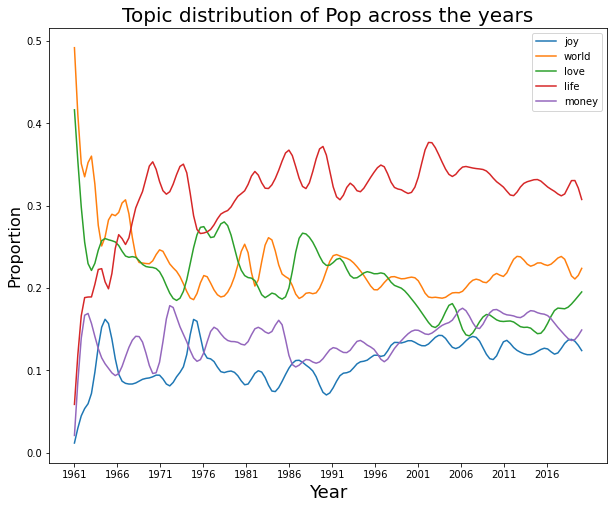

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# plot the 5 topic 
TOPICS2PLOT = ['joy', 'world', 'love','life','money'] 
TOPICS2PLOT
labels = {}
for x in TOPICS2PLOT:
  labels[x] = '{}'.format(x)

plt.figure(figsize=(10,8))
for topic in TOPICS2PLOT:
    smooth_x, smooth_y = smooth(grouped_by_year.index, grouped_by_year['{}'.format(topic)])
    plt.plot(smooth_x, smooth_y, label=labels[topic])

plt.title('Topic distribution of Pop across the years', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Proportion', fontsize=16) 
plt.xticks(np.arange(1961, 2021, 5), fontsize=10)
plt.legend()

In [ ]:
df_pop.year.value_counts()

In the above analysis, we can see the development of pop genre after 2000 are more stable without considerable changes between different topics as well as more data(songs) each year. Additonally, in order to avoid considerable gaps between generation to influece the results, I filter out the out-of-date data before 2000. Overall, I would like to analyze the period from 2000 to 2020 that have a closer pattern and enough songs for each year. 

## Step 2. Classification: BERT

I will choose the data from 2000 to 2020 to train the BERT and predict in the following stpes.

In [53]:
# Choose the period from 2000 to 2020
df_2000 = df[df.year >= 2000]
# Randomly select 100 samples from pop and 100 samples from others
df_sub = df_2000[df_2000.label == 1].sample(n=5000).append(df_2000[df_2000.label != 1].sample(n=5000))
df_sub

,song,year,artist,genre,lyrics,label
116019,genghis-khan,2004,dschinghis-khan,Pop,They rode the fastest horses left the wind beh...,1
61540,zero-gravity,2009,david-archuleta,Pop,Tell me what you did to me Just there beneath ...,1
61546,love-don-t-hate,2013,david-archuleta,Pop,You always ask me Those words I say And tellin...,1
196492,clown,2020,emeli-sande,Pop,I guess it's funnier from where you're standin...,1
74410,millionaire,2016,cash-cash,Pop,I feel like a millionaire I feel like a millio...,1
...,...,...,...,...,...,...
89348,i-ve-got-a-feeling-naked-version,2014,beatles,Rock,I've got a feeling a feeling deep inside Oh ye...,0
174093,that-s-why,2008,craig-morgan,Country,My alarm goes off early Can't afford to be lat...,0
122185,you-got-it,2011,etta-james,R&B,Well you're making a big mistake girl Trying t...,0
155019,feeling-like,2019,drake,Hip-Hop,You know you know How the story go You just ju...,0


In [ ]:
!pip install transformers

In [54]:
# Train/test/val split
from sklearn.model_selection import train_test_split

data = df_sub

X = list(data.lyrics.values) # the lyrics --> X
y = list(data.label.values) # the labels we want to predict --> Y
labels = ['Not Pop', 'Pop']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [55]:
# Vectorization
import tensorflow as tf
from transformers import DistilBertTokenizerFast

# Necessarily use the tokenizer of BERT to pre-process
data = df_sub
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

# Following the setting in exercise 2.1
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128) # convert input strings to BERT encodings
test_encodings = tokenizer(X_test, truncation=True, padding=True,  max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(16) # convert the encodings to Tensorflow objects
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(64)

In [56]:
# Compile the model
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', 
                                                           num_labels=len(labels))
callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, 
                      mode='min', baseline=None, 
                      restore_best_weights=True)]

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Set the optimizer
model.compile(optimizer=optimizer, loss=loss)

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it fo

In [57]:
# Train the model
model.fit(train_dataset, 
            epochs=5, # work with optimizer
          callbacks=callbacks, 
          validation_data=val_dataset,
           batch_size=16)

Epoch 1/5
500/500 [==============================] - 224s 427ms/step - loss: 0.6387 - val_loss: 0.6187
Epoch 2/5
500/500 [==============================] - 212s 424ms/step - loss: 0.5670 - val_loss: 0.6829
Epoch 3/5
500/500 [==============================] - 212s 424ms/step - loss: 0.4270 - val_loss: 0.7301
Epoch 4/5
500/500 [==============================] - 212s 424ms/step - loss: 0.2601 - val_loss: 1.0157


In [58]:
# Evaluate the perfomance
import numpy as np
from sklearn.metrics import classification_report 

logits = model.predict(test_dataset)
y_preds = np.argmax(logits[0], axis=1)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64       498
           1       0.65      0.74      0.69       502

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



In [4]:
# Load the new_lyrics
new_lyrics = open("/content/drive/MyDrive/Data/New lyrics_exam 1.3.txt").read()
new_lyrics = new_lyrics.replace('\n', '')

In [60]:
# we can also test the model with label data
# new_examples = df_sub.iloc[:5, 4].tolist()

# Predict the new lyrics is pop or not
new_examples = [new_lyrics]

# Pre-processing the new lyrics
examples_encodings = tokenizer(new_examples, truncation=True, padding=True)
examples_encodings = tf.data.Dataset.from_tensor_slices((
                    dict(examples_encodings)
                      )).batch(64)
pred_logits = model.predict(examples_encodings)

for i, logits in enumerate(pred_logits[0]):
    prediction = np.argmax(logits)
    print("{}".format(labels[prediction]))
    

Pop


In [61]:
# Get the probability by converting the logits to probabilities
softmax = lambda x : np.exp(x)/sum(np.exp(x))
for i, logits in enumerate(pred_logits[0]):
    proba = softmax(logits)
    probability_not_clickbait = proba[0]
    probability_clickbait = proba[1]
    print("{}% not pop; {}% pop".format( round(probability_not_clickbait, 3),
                                         round(probability_clickbait, 3)))

0.45100000500679016% not pop; 0.5490000247955322% pop


##  Analysis the new lyrics

In [5]:
import spacy
# Analysis the new lyrics
text = new_lyrics
nlp = spacy.load("en_core_web_sm")
processed_text = nlp(text)
tokenized_text_new = [word.lemma_ for word in processed_text if word.pos_ == 'NOUN' and not word.is_stop]

In [9]:
from collections import Counter
import pandas as pd

# See the most frequent words

word_counts = Counter(tokenized_text_new)
new = word_counts.most_common()[:13]
new = pd.DataFrame(new, columns=['word', 'times']) 
new.sort_values('times', ascending=False)

,word,times
0,world,14
1,end,10
2,sky,4
3,rain,4
4,pain,4
5,music,4
6,lie,3
7,heart,2
8,lockdown,2
9,eye,2


In [20]:
word_counts = Counter(tokenized_texts_pop_frq)
pop = word_counts.most_common()[:13] # set the same the number of new lyrics
pop = pd.DataFrame(pop, columns=['word', 'times']) 
pop.sort_values('times', ascending=False)

,word,times
0,love,36529
1,time,22527
2,baby,18065
3,way,17735
4,heart,17131
5,day,13628
6,life,12969
7,night,12349
8,girl,11907
9,thing,11580


In [21]:
!pip install matplotlib-venn-wordcloud

  Created wheel for matplotlib-venn-wordcloud: filename=matplotlib_venn_wordcloud-0.2.5-py3-none-any.whl size=10810 sha256=b64f0aaf2c30f3b06077b778bd770b34ba3434be0681572c62421d421644b1cc
  Stored in directory: /root/.cache/pip/wheels/b8/7e/25/80c14d2abb358c493d7772fe3a9370a7742fc1ae68968c33ef
Successfully built matplotlib-venn-wordcloud


Text(0.5, 1.0, 'The frequent words')

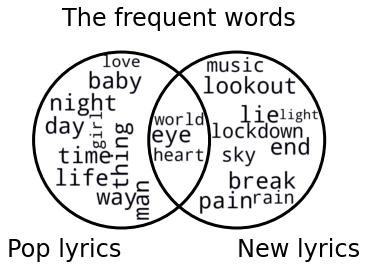

In [29]:
# Create a wordcloud to visualize their word relationship
from matplotlib_venn_wordcloud import venn2_wordcloud
import matplotlib.pyplot as plt

set1 = set(pop.word)
set2 = set(new.word)

%matplotlib inline
venn2_wordcloud([set1, set2],('Pop lyrics', 'New lyrics'))
plt.title('The frequent words', fontsize = 24)

### *Answer the question/explanation about the new lyrics (ca. 100 words)
First, if we look at the new lyrics generally, we can find there are repeated verses and words that related to a story of love. Furthermore, if we compare these words with our analysis in step (1), we can discover there are quite similar common words in the lyrics of classic pop music as we can clearly see in the cloudplot.


On the other hand, if we predict the new lyrics with the BERT model in step (2), we get the predicted outcome of "Pop song." In conclusion, the new lyrics have similar features to pop genre and the validated classification result as a pop music. 

### *Interpretation and conclusion (ca. 200 words)
In the step 1, we analyze the lyrics of the typical pop songs that have a lot of repeated words and sentences as hook. In addition, most of the topics and lyrics express feelings about love, life and relationship between people. It is also useful to select proper data when we discover the topic distribution with time series.

In the step 2, we train a BERT model with 67% accuracy and predict the new lyrics as pop with 0.54 probability. However, I think the distinguished probability is not significant because pop song is actually a genre incorporating the popular materials and concepts from various music category. Sometimes the ambiguity of grey areas between music is hard for BERT to find the notable patterns of pop apart from other genres even by human sense, especially between pop and hip-pop.

Overall, we can combine our discovered features of a typical pop song and the predict outcome of BERT to identify whether the new lyrics form the record producer are pop genre or not. In this case, the new lyrics have similar features to pop music and have a BERT predicted result of pop. Based on above analysis, in a data-driven way, I think the new lyrics can be reckon as pop genre.